In [1]:
%matplotlib inline

import json
import requests
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

stops = set(stopwords.words("english"))
epa_ft_url = "https://storage.googleapis.com/atriskwiki/epa_fulltext.txt"
nepa_ft_url = "https://storage.googleapis.com/atriskwiki/nepa_fulltext.txt"

In [2]:
pd.set_option("display.max_rows",25)

In [3]:
import datetime

In [28]:
def StemFTfromCSV(csv_fn):
    now = datetime.datetime.now().time()
    print("[{:02d}:{:02d}:{:02d}] Opening file: {}".format(now.hour,now.minute,now.second,csv_fn))
    processedTexts = dict()
    with open(csv_fn,"r") as f:
        for ix, line in enumerate(f):
            if (ix + 1) % 1000 == 0:
                now = datetime.datetime.now().time()
                print("[{:02d}:{:02d}:{:02d}] Processing record {}".format(now.hour,now.minute,now.second,ix+1))
            try:
                ft_json = json.loads(line)
                article_id = list(ft_json.keys())[0]
                processedTexts[article_id] = GetAndCleanArticle(ft_json[article_id],fulltext=True)
            except Exception as e:
                now = datetime.datetime.now().time()
                print("[{:02d}:{:02d}:{:02d}] {}:\n{}".format(now.hour,now.minute,now.second,e,line[:140]))
            
    df_ft = pd.DataFrame.from_dict(processedTexts, orient="index")
    df_ft.index.name = 'article_id'
    df_ft.columns = ['ft_stems']
            
    return df_ft

In [35]:
def GetFTLength(fulltext):
    fulltext = re.sub(r"\n"," ",fulltext)
    fulltext = re.sub(r"[^A-Za-z ]","",fulltext)
    return len(fulltext.split())

In [29]:
stemmed_fts = StemFTfromCSV("ArticleFulltexts/epa_fulltext.txt")

[10:08:52] Opening file: ArticleFulltexts/epa_fulltext.txt
[10:09:37] Processing record 1000
[10:10:05] Processing record 2000
[10:10:25] Processing record 3000
[10:10:39] Processing record 4000
[10:10:55] Processing record 5000
[10:11:09] Processing record 6000
[10:11:20] Processing record 7000


In [30]:
import os
path = "ArticleFulltexts/"
for filename in os.listdir(path):
    if filename == "epa_fulltext.txt":
        pass
    else:
        stemmed = StemFTfromCSV(path + filename)
        stemmed_fts = pd.concat([stemmed_fts, stemmed])


[10:12:06] Opening file: ArticleFulltexts/071816_fulltext_batch1.txt
[10:12:22] Processing record 1000
[10:12:35] Processing record 2000
[10:12:44] Processing record 3000
[10:12:52] Processing record 4000
[10:12:59] Processing record 5000
[10:13:04] Processing record 6000
[10:13:10] Processing record 7000
[10:13:17] Processing record 8000
[10:13:22] Processing record 9000
[10:13:26] Opening file: ArticleFulltexts/071816_fulltext_batch2.txt
[10:13:42] Processing record 1000
[10:13:53] Processing record 2000
[10:14:02] Processing record 3000
[10:14:09] Processing record 4000
[10:14:14] Processing record 5000
[10:14:21] Processing record 6000
[10:14:26] Processing record 7000
[10:14:32] Processing record 8000
[10:14:34] expected string or bytes-like object:
{"51074306": null}

[10:14:34] Opening file: ArticleFulltexts/071816_fulltext_batch3.txt
[10:14:50] Processing record 1000
[10:15:01] Processing record 2000
[10:15:10] Processing record 3000
[10:15:19] Processing record 4000
[10:15:26]

In [36]:
articleLength = dict()
for filename in os.listdir(path):
    with open(path + filename) as f:
        for line in f:
            try:
                ft_json = json.loads(line)
                article_id = list(ft_json.keys())[0]
                articleLength[article_id] = GetFTLength(ft_json[article_id])
            except:
                pass

In [38]:
df_length = pd.DataFrame.from_dict(articleLength,orient='index')
df_length.index.name = 'article_id'
df_length.columns = ['article_words']

,article_words
article_id,
23014087,1640
38808352,1473
4015641,2437
16710956,293
1139408,745
178835,1960
425454,1783
23008549,240
7276543,147


In [39]:
import pymysql

# your username and password go here!
creds = {'user': 'brian', 
         'pswd': 'farley'} 


connection = pymysql.connect(host="atriskwiki.cbprs6vpqcbz.us-west-1.rds.amazonaws.com",
                            user=creds['user'],
                            password=creds['pswd'],
                            port=3306,
                            db="atriskwiki",
                            charset="utf8")

cur = connection.cursor()

In [45]:
idQ = 'SELECT page_id, page_is_ep FROM core WHERE page_batch < 99'
cur.execute(idQ)

id_and_ep = pd.DataFrame(list(cur.fetchall()),columns=['article_id','page_is_ep'])
id_and_ep.index = id_and_ep['article_id']
del id_and_ep['article_id']
id_and_ep



,page_is_ep
article_id,
25,1
290,1
307,1
308,1
316,0
572,0
594,1
615,0
620,1


In [58]:
df_length.index = df_length.index.astype(int)
stemmed_fts.index = stemmed_fts.index.astype(int)
stemmed_with_info = stemmed_fts.merge(df_length.merge(id_and_ep, how='inner', left_index=True, right_index=True),how='inner',left_index=True, right_index=True)
stemmed_with_info

,ft_stems,article_words,page_is_ep
article_id,,,
25,autism neurodevelopment disord character impai...,7674,1
290,name e plural ae first letter first vowel iso ...,1732,1
307,abraham lincoln ebrhm lkn februari april th pr...,15026,1
308,aristotl rsttl greek aristotl aristotl bc gree...,10815,1
316,academi award best product design recogn achie...,143,0
572,agricultur scienc broad multidisciplinari fiel...,1310,0
594,apollo attic ionic homer greek apolln gen dori...,11769,1
615,american footbal confer afc one two confer nat...,722,0
620,anim farm allegor dystopian novella georg orwe...,6092,1


In [4]:
def ScrapeAndStemIntros(fulltextsURL):
    """Retrieves JSON-formatted article fulltexts from the specified URL and returns a pandas.DataFrame
    containing stemmed introduction strings for each article, indexed by article_id
    """
    print("Getting remote file...")
    fulltexts = requests.get(fulltextsURL).text.split("\n")
    print("File retrieved and split!")
    processedTexts = dict()
    
    print("Stemming records...")
    for (ix, ft) in enumerate(fulltexts):
        if (ix + 1) % 500 == 0:
            print("Stemming record {}.".format(ix + 1))
        try:
            ft_json = json.loads(ft)
            article_id = list(ft_json.keys())[0]
            processedTexts[article_id] = GetAndCleanArticle(ft_json[article_id])
        except:
            print("RECORD FAILED: {} {}".format(article_id,ft))
    
    df_intro = pd.DataFrame.from_dict(processedTexts, orient="index")
    df_intro.index.name = 'article_id'
    df_intro.columns = ['intro_stems']
    
    return df_intro

In [10]:
def GetAndCleanArticle(text, fulltext=False):
    """Expects a string containing a wikipedia article formatted with explaintext and exsectionformat=wiki
    Returns a list containing all Porter stemmed non-stop words from the introductory section of the article
    (can be set to process the entire article with fulltext=True)"""
    if not fulltext:
        intro = re.compile("==.*?==").split(text)[0]
    else:
        intro = text
    intro = re.sub(r"\n"," ",intro)
    intro = re.sub(r"[^A-Za-z ]","",intro)
    intro = intro.lower()
    intro_words = intro.split()
    intro_words = [stemmer.stem(w) for w in intro_words if w not in stops]
    return " ".join(intro_words)

In [31]:
def VectorizeMostCommonFeatures(dataframe, num_features):
    """Identifies the num_features most common features from a dataframe generated by ScrapeAndStemIntros
    containing space-delimited stemmed strings.
    """
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None, max_features = num_features)
    vec_words = vectorizer.fit_transform(dataframe["ft_stems"])
    vocab = vectorizer.get_feature_names()
    count_vocab = vec_words.toarray()
    count_df = pd.DataFrame(count_vocab, columns=vocab, index=dataframe.index)
    return count_df

In [95]:
def VectorizeVocabFeatures(dataframe, vocab):
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None, vocabulary=vocab)
    vec_words = vectorizer.fit_transform(dataframe["ft_stems"])
    features = vectorizer.get_feature_names()
    count_vocab = vec_words.toarray()
    return pd.DataFrame(count_vocab, columns=features, index=dataframe.index)

In [60]:
total_vec_count = VectorizeMostCommonFeatures(stemmed_with_info, 10000)
epa_vec_count = VectorizeMostCommonFeatures(stemmed_with_info[stemmed_with_info['page_is_ep'] == 1],10000)
samp_vec_count = VectorizeMostCommonFeatures(stemmed_with_info[stemmed_with_info['page_is_ep'] == 0],10000)

In [65]:
total_words = set(total_vec_count.columns)
epa_words = set(epa_vec_count.columns)
samp_words = set(samp_vec_count.columns)

epa_only = epa_words - samp_words
samp_only = samp_words - epa_words
union_words = epa_words | samp_words

In [66]:
print(len(epa_only))
print(len(samp_only))
print(len(union_words))

1715
1715
11715


In [71]:
total_sum = total_vec_count.sum(axis=0)
epa_sum = epa_vec_count.sum(axis=0)
samp_sum = samp_vec_count.sum(axis=0)

In [75]:
epa_sum[epa_sum.index.isin(epa_only)].sort_values(ascending=False)

scientolog           2692
peni                  884
cena                  761
wrestlemania          750
megatron              742
cannabi               694
sperm                 652
jihad                 630
sharif                617
beckham               612
orton                 611
zimmerman             608
                     ... 
kyli                  121
protoindoeuropean     121
agrarian              121
sylvest               121
dumbo                 121
shnen                 121
jafar                 121
theropod              121
dhoom                 121
donni                 121
purif                 121
dutt                  121
dtype: int64

In [76]:
samp_sum[samp_sum.index.isin(samp_only)].sort_values(ascending=False)

lc              4429
terminu         2360
nonfamili       2313
freeway         2239
mathbf          2233
somerset        1931
tram            1900
saskatchewan    1800
turret          1800
duchi           1792
durham          1705
brighton        1703
                ... 
woodward         454
fran             454
collier          454
tuvalu           454
atkin            454
cheng            453
slovenian        453
derrick          453
multipurpos      453
nola             453
quarrel          453
godfrey          453
dtype: int64

In [96]:
union_vec_count = VectorizeVocabFeatures(stemmed_with_info,union_words)

In [102]:
sum(union_vec_count['sperm'])

998

In [98]:
union_present = union_vec_count > np.zeros_like(union_vec_count)

In [104]:
union_present

,aa,aaa,aachen,aaliyah,aarhu,aaron,ab,abandon,abba,abbey,...,zombi,zone,zoo,zoolog,zoroastrian,zrich,zu,zuckerberg,zur,zurich
article_id,,,,,,,,,,,,,,,,,,,,,
25,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
290,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
307,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
308,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
316,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
572,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
594,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
615,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
620,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [105]:
union_pres_freq = union_present.sum(axis=0) / len(union_present)


KeyError: 'article_id'

In [108]:
ep_ids = stemmed_with_info[stemmed_with_info['page_is_ep'] == 1].index
samp_ids = stemmed_with_info[stemmed_with_info['page_is_ep'] == 0].index
union_pres_freq_ep = union_present[union_present.index.isin(ep_ids)].sum(axis=0) / len(ep_ids)
union_pres_freq_sample = union_present[union_present.index.isin(samp_ids)].sum(axis=0) / len(samp_ids)

In [109]:
union_pres_freq_ep.sort_values(ascending=False)

refer          0.940872
also           0.880813
extern         0.785012
link           0.781424
one            0.777438
first          0.761892
includ         0.737842
time           0.722695
two            0.714855
new            0.714457
year           0.708743
state          0.689476
                 ...   
espuela        0.000266
rq             0.000266
tq             0.000133
xaviax         0.000133
gmina          0.000133
sogod          0.000133
mathcal        0.000133
seenment       0.000133
metald         0.000133
hbner          0.000000
schiffermul    0.000000
anoli          0.000000
dtype: float64

In [110]:
union_pres_freq_sample.sort_values(ascending=False)

refer       0.907735
also        0.720619
link        0.640839
extern      0.632947
first       0.607831
one         0.587718
two         0.543440
year        0.539124
includ      0.530137
time        0.517507
new         0.514564
state       0.467646
              ...   
sharpay     0.000040
espuela     0.000026
lulzsec     0.000026
castiel     0.000026
xaviax      0.000013
nyit        0.000013
gamerg      0.000013
metald      0.000013
sogod       0.000013
shaider     0.000000
spielban    0.000000
seenment    0.000000
dtype: float64

In [118]:
vocab_present = pd.concat([union_pres_freq,union_pres_freq_ep,union_pres_freq_sample],axis=1)
vocab_present.columns=['all','ep','sample']
vocab_present['fold_ep'] = vocab_present['ep'] / vocab_present['sample']
vocab_present['fold_ep'].sort_values(ascending=False)
vocab_present.to_csv(path_or_buf="union_vocab.csv")

In [120]:
union_present[(union_present['dmoz'] > 0) & union_present.index.isin(ep_ids)].index

Int64Index([      25,      308,      624,      736,      737,      783,
                 800,      863,     1537,     1806,
            ...
            26807275, 28249265, 28329803, 37729052, 40017873, 40817590,
            41688778, 44275267, 45645094, 47398645],
           dtype='int64', name='article_id', length=440)

In [9]:
epa_vec_count = VectorizeMostCommonFeatures(epa_stem_intros, 5000)
nepa_vec_count = VectorizeMostCommonFeatures(nepa_stem_intros, 5000)

In [44]:
epa_entries_with_words = epa_vec_count[epa_vec_count.sum(axis=1) > 0].index
epa_vecs_with_words = epa_vec_count[epa_vec_count.sum(axis=1) > 0].as_matrix()

In [29]:
counts = np.sum(epa_vec_count, axis=0)
epa_vec_count.shape[0]

7526

In [10]:
def ProcessWordOccurrences(vec_count_df):
    '''Given a dataframe (rows: articles, cols: word counts) containg the output of VectorizeMostCommonFeatures, output a dataframe
    containing the number of occurrences of each word across the dataset, the number of articles with at least
    one occurrence of the word, and the fraction of articles with at least once occurrence.'''
    vocab = vec_count_df.columns.values
    count_by_word = np.sum(vec_count_df, axis=0)
    
    present = vec_count_df > np.zeros(vec_count_df.shape)
    present_by_word = np.sum(present, axis=0)
    present_by_word_frac = present_by_word / vec_count_df.shape[0]
    
    df = pd.concat([count_by_word,present_by_word,present_by_word_frac],axis=1)
    df.columns = ['occurences','articles','frac_of_articles']
    return df

In [11]:
epa_occurrences = ProcessWordOccurrences(epa_vec_count)
nepa_occurrences = ProcessWordOccurrences(nepa_vec_count)

In [13]:
occ = pd.merge(epa_occurrences, nepa_occurrences, left_index=True, right_index=True, suffixes=('_epa','_nepa'), indicator=True)

In [41]:
occ.to_csv(path_or_buf="BOW_5000.csv")

In [42]:
occ_all = pd.merge(epa_occurences, nepa_occurrences, how="outer", left_index=True, right_index=True, suffixes=('_epa','_nepa'), indicator=True)
#occ_all.to_csv(path_or_buf="BOW_5000_ALL.csv")

In [14]:
def UnitVector(vector):
    return vector/np.linalg.norm(vector)

def AngleBetween(v1, v2):
    v1_u = UnitVector(v1)
    v2_u = UnitVector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0,1.0))

In [55]:
epa_norms = np.linalg.norm(epa_vecs_with_words, axis=1) #calculates norms of row vectors
epa_vecs_normed = epa_vecs_with_words / epa_norms[:,None] #unitizes row vectors
distances = 180 * np.arccos(np.clip(np.dot(epa_vecs_normed,epa_vecs_normed.T),-1.0, 1.0)) / np.pi #calculates the angle
#in degrees between each pair of articles
epa_article_distances = pd.DataFrame(distances, index=epa_entries_with_words, columns=epa_entries_with_words)

In [84]:
epa_entries_with_words



Index(['2872345', '598524', '35901300', '6110688', '22705211', '4996831',
       '15296435', '8933089', '23324667', '18940588',
       ...
       '36599245', '12120000', '83019', '81083', '21552009', '47125',
       '10483209', '33947707', '33591033', '405134'],
      dtype='object', name='article_id', length=7489)

In [72]:
def GetMostSimilar(article_id, numrecords=25):
    '''Given an article ID, return a list of the most similar (i.e., lowest angle) articles in the dataset'''
    return epa_article_distances[str(article_id)].sort_values()[:numrecords+1]

GetMostSimilar(23324667)

article_id
23324667     0.000002
728093      64.872575
22785154    67.860228
241547      67.921119
52271       68.460381
2529569     69.138747
161041      69.292024
4689709     69.506649
72671       69.720620
579570      69.875869
13076       70.075230
993655      70.356555
1102585     70.560807
67119       70.587929
19279158    70.603681
415700      70.650424
451733      70.919237
24117       70.935768
15674472    70.950998
5043544     70.962876
419342      71.280068
376619      71.508761
169798      71.606063
20652023    71.636490
149333      71.678676
69926       71.956406
Name: 23324667, dtype: float64

<function matplotlib.pyplot.show>

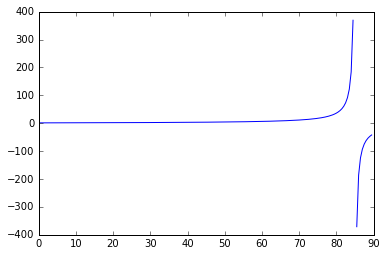

In [130]:
#distance scaling function, engineered to increase slowly up to 70 and rapidly thereafter
x_plot = np.arange(0,90,0.5)
y_plot = (100 + x_plot) / (85 - x_plot) 
plt.plot(x_plot, y_plot)
plt.show

In [132]:
scaled_distances = (100 + distances) / (85 - distances)
scaled_distances[scaled_distances <= 0] = 400 #sets negative values (i.e., angles above 85) to an arbitrarily large distance

array([[   1.17647062,  400.        ,  398.02583958, ...,  355.26924076,
         105.74430349,  400.        ],
       [ 400.        ,    1.17647059,  400.        , ...,  400.        ,
         400.        ,  400.        ],
       [ 398.02583958,  400.        ,    1.17647063, ...,  400.        ,
         400.        ,  400.        ],
       ..., 
       [ 355.26924076,  400.        ,  400.        , ...,    1.17647059,
         400.        ,  400.        ],
       [ 105.74430349,  400.        ,  400.        , ...,  400.        ,
           1.17647059,  400.        ],
       [ 400.        ,  400.        ,  400.        , ...,  400.        ,
         400.        ,    1.17647059]])

In [133]:
from sklearn.cluster import DBSCAN

topic_DBSCAN = DBSCAN(eps=12, min_samples=10, metric='precomputed')
topic_labels = topic_DBSCAN.fit_predict(scaled_distances)

In [146]:
def CharacterizeClassPop(topic_labels):
    '''Given an array of class labels (the output from DBSCAN.fit_predict()), determine how many
    non-noise clusters (i.e., some number besides -1) were assigned, what fraction of articles were assigned to a
    non-noise cluster, and the average, median, and max size of the population of clusters. Returns a dict.'''
    classCounts = np.array(np.unique(topic_labels, return_counts=True)).T #each row contains the class label and the number of occurrences
    assignedClasses = classCounts[1:]
    numClust = assignedClasses.shape[0]
    fracInClust = np.sum(assignedClasses[:,1]) / np.sum(classCounts[:,1])
    avgClustSize = np.sum(assignedClasses[:,1]) / numClust
    medianClustSize = np.median(assignedClasses[:,1])
    maxClustSize = np.max(assignedClasses[:,1])
    
    return {'numClusters':numClust,
           'coverage':fracInClust,
           'avgClusterSize':avgClustSize,
           'medianClusterSize':medianClustSize,
           'maxClusterSize':maxClustSize}

In [243]:
def InfoAboutEachClass(topic_labels):
    '''Given an array of class labels (the output from DBSCAN.fit_predict()), select <= 10 representative
    articles from each class, and the 10 most frequently present words from that cluster. Returns a nested dict.'''
    id_topic = pd.DataFrame(topic_labels, index=epa_entries_with_words, columns=['DB_class'])
    vec_words_by_class = pd.merge(epa_vec_count, id_topic,
                                 how='inner', left_index=True, right_index=True)
    
    id_topic.index = id_topic.index.map(int)
    titles_by_class = pd.merge(epa_titles, id_topic, 
                               how='inner', left_index=True, right_index=True)
    
    classInfo = dict()
    for k in np.unique(topic_labels)[1:].tolist():
        classInfo[k] = dict()
        k_words = vec_words_by_class[vec_words_by_class['DB_class'] == k]
        classMem = k_words.shape[0]
        classInfo[k]['class_members'] = classMem
        present = k_words > np.zeros(k_words.shape)
        present_by_word = np.sum(present, axis=0)
        present_by_word_frac = present_by_word / k_words.shape[0]
        classInfo[k]['top_words'] = present_by_word_frac.sort_values(ascending=False)[:10].to_dict()
        
        sampSize = min(classMem, 10)
        k_titles = titles_by_class[titles_by_class['DB_class'] == k].sample(n=sampSize)
        classInfo[k]['rep_titles'] = k_titles['page_title'].tolist()
    return classInfo

In [223]:
def PrintInfoAboutEachClass(topic_labels):
    '''Given an array of class labels (the output from DBSCAN.fit_predict()), run InfoAboutEachClass() and format
    its output for printing. Returns a formatted string.'''
    
    printInfo = InfoAboutEachClass(topic_labels)
    report = ""
    for key in sorted(printInfo):
        report += "========================\n"
        report += "CLUSTER {}: {} MEMBERS\n\n".format(key, printInfo[key]['class_members'])
        
        report += "Representative articles:\n"
        for article in printInfo[key]['rep_titles']:
            report += article
            report += "\n"
        report += "\nMost common terms:\n"
        for word in sorted(printInfo[key]['top_words'], key=printInfo[key]['top_words'].get, reverse=True):
            report += "{}: {:.3f}\n".format(word, printInfo[key]['top_words'][word])
        report += "========================\n"
    return report

CLUSTER 0: 5275 MEMBERS

Representative articles:
Victoria_Justice
Michael_Oher
Suicide_Squad_(film)
Albert_Pyun
Machete_(film)
Landon_Hedges
List_of_Hail_Mary_passes_in_American_football
Puerto_Ricans
Mahatma_Gandhi
List_of_Teletubbies_episodes_and_videos

Most common terms:
also: 0.383
first: 0.317
american: 0.316
one: 0.302
born: 0.300
includ: 0.296
state: 0.272
known: 0.269
year: 0.241
unit: 0.240
CLUSTER 1: 14 MEMBERS

Representative articles:
Water
Evaporation
Cactus
Rain
Renewable_energy
Water_fluoridation
Ocean
Coral_reef
Water_fluoridation_controversy
Photosynthesis

Most common terms:
DB_class: 1.000
water: 0.929
use: 0.786
also: 0.714
form: 0.643
earth: 0.571
organ: 0.500
exist: 0.500
mani: 0.500
global: 0.500
CLUSTER 2: 13 MEMBERS

Representative articles:
Earth
Google_Earth
Moon
Jupiter
Uranus
Solar_eclipse
Mercury_(element)
Sky
Mercury_(planet)
Venus

Most common terms:
DB_class: 1.000
earth: 0.923
sun: 0.769
moon: 0.769
solar: 0.769
planet: 0.769
system: 0.692
orbit: 0.6

In [248]:
def RunAndAnalyzeDBSCAN(eps, min_samples, scaled_distances):
    '''Given a value for epsilon, the minimum number of samples required for a core point, and a matrix of
    precomputed distances, create a DBSCAN classifier, use it to fit and predict based on the supplied distances, 
    and analyze the output using CharacterizeClassPop and PrintInfoAboutEachClass. Returns a csv formatted string
    containing epsilon, min_samples, numClusters, coverage, avgClusterSize, medianClusterSize, and maxClusterSize'''
    from sklearn.cluster import DBSCAN
    clust = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    topic_labels = clust.fit_predict(scaled_distances)
    numClusters = np.unique(topic_labels).shape[0]
    if numClusters > 1:
        cp = CharacterizeClassPop(topic_labels)
        report = PrintInfoAboutEachClass(topic_labels)
    
        reportFN = "candidate_clusters/{}_{}_clustReport.txt".format(eps, min_samples)
        with open(reportFN, "w") as f:
            f.write(report)
    
        return "{},{},{},{:.3f},{:.0f},{:.0f},{}".format(eps,min_samples,cp['numClusters'],cp['coverage'],cp['avgClusterSize'],
                                        cp['medianClusterSize'],cp['maxClusterSize'])
    else:
        return "{},{},0,0,0,0,0".format(eps,min_samples)

In [249]:
candidate_eps = range(2,13)
candidate_samples = [2,5,10,20,50,100]
with open("DBSCAN_metrics.txt","w") as d:
    d.write("epsilon,min_samples,num_clusters,coverage,avg_cluster_size,median_cluster_size,max_cluster_size\n")
    for eps in candidate_eps:
        for samples in candidate_samples:
            output = RunAndAnalyzeDBSCAN(eps, samples, scaled_distances)
            d.write(output)
            d.write("\n")


,page_title,0
2872345,Lupe_Fiasco,0
598524,Ariel_(city),0
35901300,Bal_des_débutantes,-1
6110688,Splitting_of_the_moon,0
22705211,Southsound_Radio,0
4996831,Dean_Winchester,0
15296435,Faget,0
8933089,List_of_Sindhi-language_poets,0
23324667,Victor_Ponta,0
18940588,A.C._Milan,0
